# Project Description and Data Overview

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Variable Notes

- **Pclass:** A proxy for socio-economic status (SES) <br>
1st = Upper <br>
2nd = Middle <br>
3rd = Lower <br>

- **Age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 <br>

- **Sibsp:** The dataset defines family relations in this way... <br>
Sibling = brother, sister, stepbrother, stepsister <br>
Spouse = husband, wife (mistresses and fiancés were ignored) <br>

- **Parch:** The dataset defines family relations in this way... <br>
Parent = mother, father <br>
Child = daughter, son, stepdaughter, stepson <br>
Some children travelled only with a nanny, therefore parch=0 for them. <br>

- **Embarked:** Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Let's get started!

In [1]:
# Import relavent libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

## Clean Data for Exploration

First, we'll handle missing data in the dataset. To start off we'll visualise the missing data so that we know what we are working with.

<Axes: >

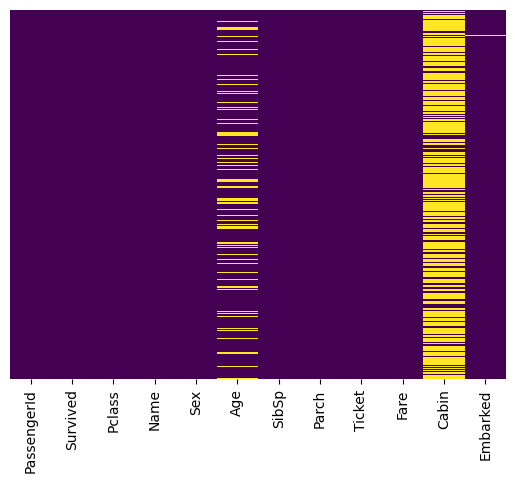

In [3]:
# Create a heatmap for visualisation

sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### From the heatmap we can make 2 notes:
1. Age: Small enough for reasonable replacement with some form of imputation. 
2. Cabin: There is too little data to work with. 


#### Imputation Strategy

We use the median age per passenger class (Pclass) to impute missing age values. This approach is preferred over a single overall median because it preserves the age distribution within each class. For example, the average age of passengers in first class is likely different from that in third class, so imputing with class-specific medians provides more accurate representations of age groups.

In [4]:
# Function to impute missing age values based on Pclass

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return train_data[train_data["Pclass"] == 1]['Age'].mean().astype(int)
        elif Pclass == 2:
            return train_data[train_data["Pclass"] == 2]['Age'].mean().astype(int)
        else:
            return train_data[train_data["Pclass"] == 3]['Age'].mean().astype(int)
    else:
        return Age

**Note:** <br>
We are assuming there is consistency between the two data sets and applying imputation from training_data over both data sets.

In [5]:
# Impute missing age values

train_data['Age'] = train_data[['Age','Pclass']].apply(impute_age, axis=1)
test_data['Age'] = test_data[['Age','Pclass']].apply(impute_age, axis=1)

# Drop missing data over both datasets except for the target column in test_data 

train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

<Axes: >

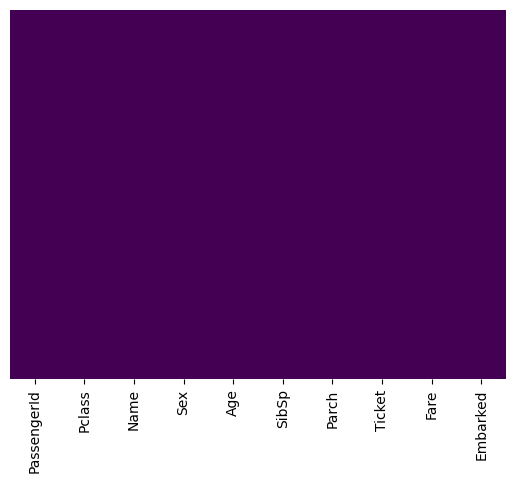

In [6]:
# Visualize missing data after imputation

sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

This looks perfect to move onto the next part of the project!

## Explroratory Data Analysis (on Training Data Only):

#### Data Leakage and Realistic Modeling
Now, let's understand why we perform exploratory data analysis (EDA) only on the training data and what data leakage is.

Data leakage occurs when information from outside the training dataset is used to create the model. For example, if we used information from the test dataset to make decisions about handling missing data or to create features, the model's performance metrics would not accurately represent how it would perform on unseen data (test set). By performing EDA and data preprocessing steps only on the training dataset, we prevent data leakage and ensure that our model is trained on realistic, unseen data scenarios.

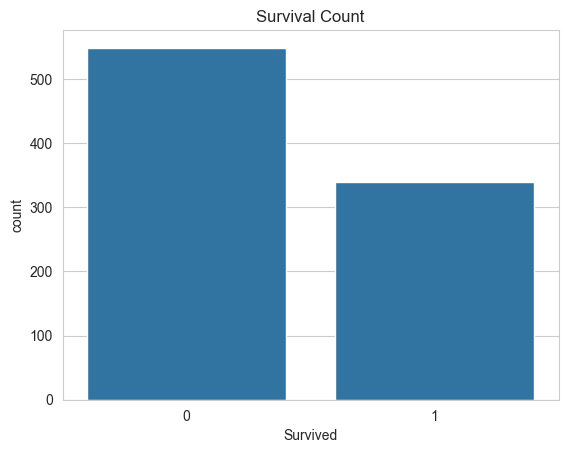

In [7]:
# Set seaborn style
sns.set_style('whitegrid')

# Plot ratio of target labels
sns.countplot(x="Survived", data=train_data)
plt.title('Survival Count')
plt.show()

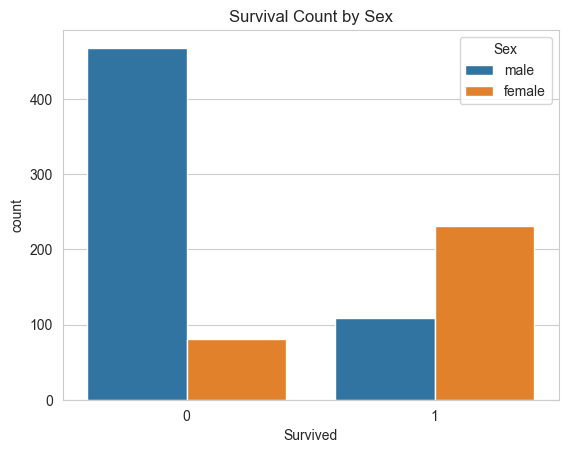

In [8]:
# Plot survival count with a hue of sex
sns.countplot(x="Survived", hue="Sex", data=train_data)
plt.title('Survival Count by Sex')
plt.show()

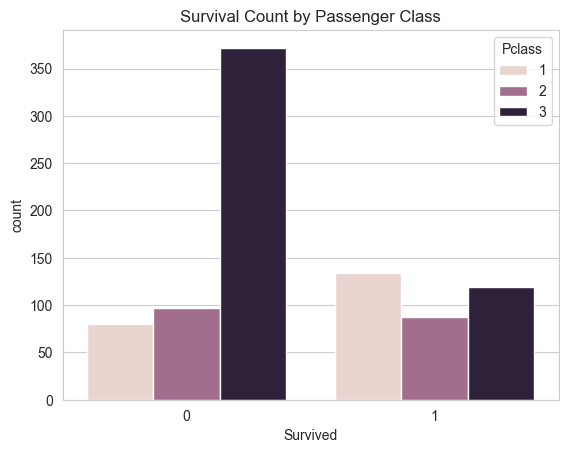

In [9]:
# Plot survival count with a hue of passenger class
sns.countplot(x="Survived", hue="Pclass", data=train_data)
plt.title('Survival Count by Passenger Class')
plt.show()

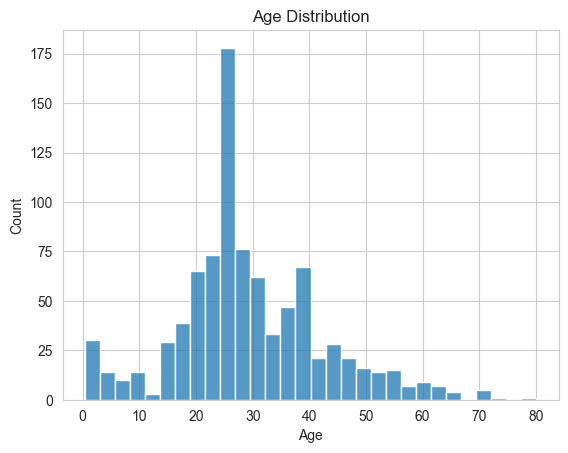

In [10]:
# Plot age distribution of passengers on the Titanic
sns.histplot(train_data['Age'].dropna(), kde=False, bins=30)
plt.title('Age Distribution')
plt.show()

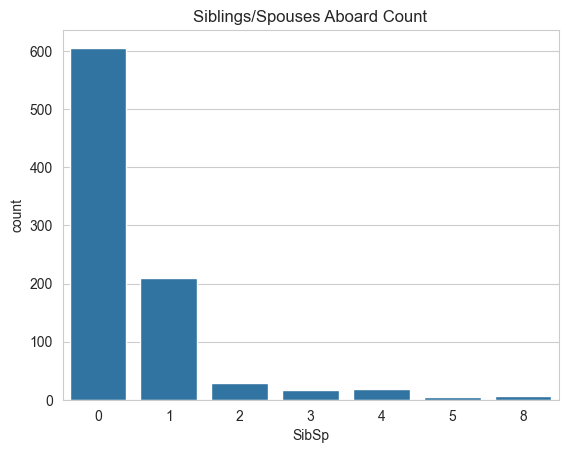

In [11]:
# Investigate the SibSp feature

sns.countplot(x='SibSp', data=train_data)
plt.title('Siblings/Spouses Aboard Count')
plt.show()

#### Note
Looks like most people did not have spouces or children on board.

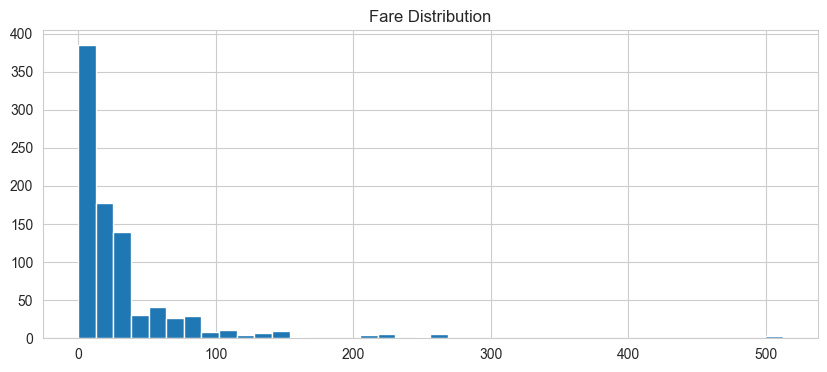

In [12]:
# Plot fare distribution
train_data['Fare'].hist(bins=40, figsize=(10, 4))
plt.title('Fare Distribution')
plt.show()

##### Note
As most passangers were in the third class it makes sense that this skewed to the cheaper side. 


### Just for fun

If you wanted to work with an interactive plot we can use the cufflinks library to do just that.

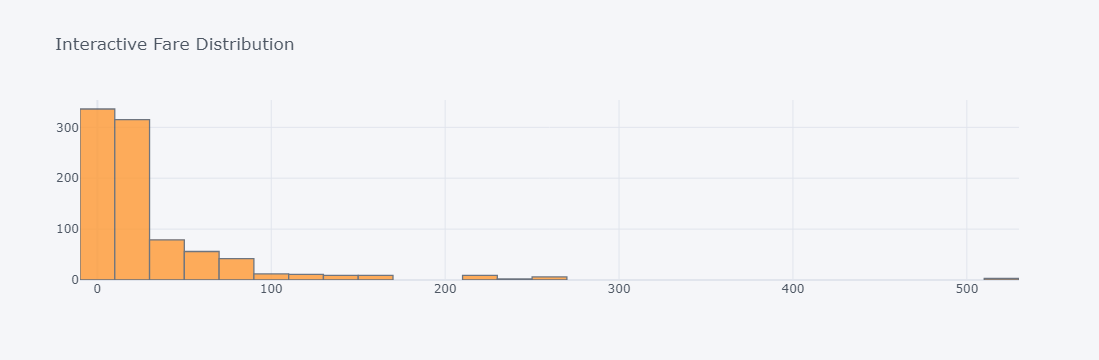

In [13]:
# Interactive fare distribution plot
cf.go_offline()
train_data["Fare"].iplot(kind='hist', bins=50, title='Interactive Fare Distribution')

## BUILD FEATURES FOR MODELLING

#### One-Hot Encoding

Categorical variables ('Sex', 'Embarked', 'Pclass') are one-hot encoded using a custom function one_hot_encode_and_concat. This transformation converts categorical variables into a format suitable for machine learning models.

In [14]:
# ONE-HOT ENCODING
# Prepare data for training by setting dummy variables

def one_hot_encode_and_concat(data, columns):
    """One-hot encode specified columns and concatenate to the dataframe."""
    encoded_columns = []
    for column in columns:
        encoded = pd.get_dummies(data[column], drop_first=True).astype(int)
        encoded_columns.append(encoded)
    return pd.concat([data] + encoded_columns, axis=1)

# Encode specified columns
columns_to_encode = ['Sex', 'Embarked', 'Pclass']
train_data_cleaned = one_hot_encode_and_concat(train_data, columns_to_encode)
test_data_cleaned = one_hot_encode_and_concat(test_data, columns_to_encode)

# Drop unnecessary columns
columns_to_drop = ['Sex', 'Embarked', 'Name', 'Ticket', 'PassengerId', 'Pclass']
train_data_cleaned.drop(columns_to_drop, axis=1, inplace=True)
test_data_cleaned.drop(columns_to_drop, axis=1, inplace=True)

#### Note

When we perform one-hot encoding the value of the feature will become the column heading and bolean values will be assigned to it. Since we need all column values to be the same in preparation for the model, we will need to make all column names a string datatype.

In [15]:
# Set all column names to strings
train_data_cleaned.columns = train_data_cleaned.columns.astype(str)
test_data_cleaned.columns = test_data_cleaned.columns.astype(str)

The data is now ready for modelling!


## BUILD AND TRAIN THE MODEL

#### Random Forest Model

I have selected the random forest model for this project as I am familiar with it and believe it will yield good results for this categorical problem of determining survival from our features.

#### Model Evaluation Strategy

In this project, we will perform 2 model evaluation strategies:
1. Cross-validation
2. Evaluating the model with a validation set

|               |                                                                                                                                              |
|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Cross-validation**   | Cross-validation is a method used to estimate how well a model will generalize to new, unseen data. It involves splitting the dataset into *k* subsets (folds). Stratified k-fold cross-validation ensures each fold has approximately the same class distribution as the entire dataset. The process involves training the model on *k−1* folds and testing it on the remaining fold, repeating this *k* times with different combinations of folds as training and testing sets each time. This ensures that every sample is used for both training and testing, and the model's performance is averaged across all splits, reducing the risk of overfitting and providing a robust estimate of the model's generalization ability. |
| **Validation set**     | Evaluating the model with a validation set complements cross-validation by simulating real-world deployment scenarios. It is distinct from the training set, used to train the model, and the test set, used to assess the model's final performance. After cross-validating the data to get a reliable estimate of the model's generalization ability, it is good practice to validate the model on a validation set to ensure the chosen hyperparameters and model configurations perform well on unseen data. This helps in preventing overfitting to the cross-validation folds and provides an additional layer of confidence that the model will generalize effectively to truly new, unseen data.                                     |



##### Why Both Strategies Are Important <br>

Complementary Roles: Cross-validation provides an overall assessment of model performance across multiple data partitions, reducing bias from a single split. It ensures that the model's performance estimates are robust and unbiased. <br>

Validation Set: Focuses on evaluating the final model's performance on a dedicated holdout set, simulating real-world deployment scenarios. It helps in making informed decisions about model selection and fine-tuning.

#### One more note about Gridsearch

GridSearchCV (Grid Search Cross-Validation) is a technique used for systematically finding the optimal combination of hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the learning process begins, such as the number of trees in a random forest or the regularization parameter in a logistic regression. GridSearchCV works by exhaustively searching through a manually specified subset of the hyperparameter space, evaluating each combination using cross-validation to determine which combination provides the best performance metrics, such as accuracy or F1 score.


In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train / Validation Split
train_data_split, validation_data_split = train_test_split(train_data_cleaned, test_size=0.2, random_state=42)

# Separate features and target
X_train_data = train_data_split.drop('Survived', axis=1)
y_train_data = train_data_split['Survived']
X_validation_data = validation_data_split.drop('Survived', axis=1)
y_validation_data = validation_data_split['Survived']

# Random Forest Model
model = RandomForestClassifier(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt', 0.5],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train_data, y_train_data)

# Print the best parameters found by GridSearchCV
print(f'Best Parameters: {grid_search.best_params_}')

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Perform cross-validation and get the accuracy scores of the best model
cv_scores = cross_val_score(best_model, X_train_data, y_train_data, cv=kf, scoring='accuracy')

# Print the cross-validation scores and mean score
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores)}')

# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_validation_data)
val_accuracy = accuracy_score(y_validation_data, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')


Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Cross-Validation Scores: [0.86013986 0.83098592 0.85211268 0.85211268 0.88028169]
Mean Cross-Validation Accuracy: 0.8551265635772678
Validation Accuracy: 0.797752808988764


### My Results

Mean Cross-Validation Accuracy: 0.8537082635674185  <br>
Validation Accuracy: 0.797752808988764


## Train on the entire training dataset for final predictions